# **Entendimento do negócio**

**Contexto:**

As doenças cardiovasculares (DCV) são a causa número 1 de morte em todo o mundo, ceifando cerca de 17,9 milhões de vidas a cada ano, o que representa 31% de todas as mortes em todo o mundo. Quatro em cada cinco mortes por DCV são devidas a ataques cardíacos e acidentes vasculares cerebrais, e um terço destas mortes ocorre prematuramente em pessoas com menos de 70 anos de idade.

A insuficiência cardíaca é um evento comum causado por DCV e este conjunto de dados contém 11 características que podem ser usadas para prever uma possível doença cardíaca.

Pessoas com doenças cardiovasculares ou que apresentam alto risco cardiovascular (devido à presença de um ou mais fatores de risco, como hipertensão, diabetes, hiperlipidemia ou doença já estabelecida)

A criação dos modelo preditivos poderão ajudar na detecção precoce.



# **Ententimento dos dados**

**Fonte de dados**
Link para download do dataset:

https://www.kaggle.com/datasets/rishidamarla/heart-disease-prediction/download?datasetVersionNumber=1




**Informações sobre o dataset**

---

1 - * **age:** *Idade do Paciente*

2 - * **sex:** *Sexo do paciente*

3 - * **Chest pain type:** *Tipo de dor no peito*

4 - * **BP:** Resting blood pressure (in mm Hg) *Pressão arterial em repouso*

5 - * **Cholesterol:** Cholestoral in mg/dl fetched via BMI sensor

6 - * **FBS over 120:** (fasting blood sugar > 120 mg/dl), 1 = True, 0 = False

7 - * **EKG results:** Resting electrocardiographic results, 0 = Normal, 1 = ST-T wave normality, 2 = Left ventricular hypertrophy

8 - * **Max HR	:** *Frequência cardíaca máxima alcançada*

9 - * **Exercise angina:** Angina induzida pelo exercício (1 = yes; 0 = no)

10 - * **ST depression:** A depressão do ST é uma alteração clássica do ECG observada em resposta à redução do fluxo sanguíneo para o músculo cardíaco.

11 - * **Slope of ST	:** Inclinação do segmento ST no pico do exercício (Value 1: upsloping ,Value 2: flat, Value 3: downsloping)

12 - * **Number of vessels fluro:**  Números de vasos fluro

13 - * **Thallium:** (3 = normal; 6 = fixed defect; 7 = reversable defect)

14 - * **Heart Disease:** Diagnóstico de doença cardíaca


## Import Libraty

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics         import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.preprocessing   import StandardScaler

import seaborn as sns
from sklearn.model_selection import GridSearchCV

## Functions

In [59]:
# Functions
def generate_metadata(dataframe):
    """
    """
    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

   # Calculando o Índice Gini e Estatística KS para o conjunto de teste

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df


def calculate_woe_iv(df, feature, target):
    """
    Calcula WOE (Weight of Evidence) e IV (Information Value) para uma variável.
    """
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    return iv

def iv_table(df, target):
    """
    Retorna uma tabela com IV para todas as variáveis em relação ao target.
    """
    iv_list = []
    for col in df.columns:
        if col == target:
            continue
        iv = calculate_woe_iv(df, col, target)
        if iv < 0.02:
            predictiveness = 'Inútil para a predição'
        elif iv < 0.1:
            predictiveness = 'Preditor Fraco'
        elif iv < 0.3:
            predictiveness = 'Preditor Moderado'
        else:
            predictiveness = 'Preditor Forte'
        iv_list.append({
            'Variável': col,
            'IV': iv,
            'Preditividade': predictiveness
        })

    return pd.DataFrame(iv_list).sort_values(by='IV', ascending=False)

def gini_normalizado(y_true, y_pred):
    import pandas as pd
    import numpy as np
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

def box_plot(dataframe):
    """
    Gera box_plot das variáveis numéricas
    """
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=dataframe[column], ax=axes[i//3, i%3], color="skyblue")
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - BoxPlot", fontsize=20, fontweight='bold', y=1.05)

def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
    importancias = None
    if hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')  # Desativa o subplot se não houver importâncias para mostrar

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.show()
    
def calcular_ks_statistic(y_true, y_score):
    import pandas as pd
    import numpy as np
    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic


## Load

---

In [4]:
# Load
df_train = pd.read_csv('Heart_Disease_Prediction.csv')
df_train.shape

(270, 14)

## Analise Exploratória

---

In [14]:
# Preview dataset
df_train.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [24]:
# Tipos de variáveis
df_train.dtypes

Age                          int64
Sex                          int64
Chest_pain_type              int64
BP                           int64
Cholesterol                  int64
FBS_over_120                 int64
EKG_results                  int64
Max_HR                       int64
Exercise_angina              int64
ST_depression              float64
Slope_of_ST                  int64
Number_of_vessels_fluro      int64
Thallium                     int64
Heart_Disease                int64
dtype: object

In [33]:
# Estatística Descritivas
df_train.describe()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


In [35]:
filtered_df = df_train[df_train['Heart_Disease'] == 1]
filtered_df.describe()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.00000,120.000000,120.00000,120.000000,120.000000,120.000000,120.000000,120.0
mean,56.591667,0.833333,3.616667,134.441667,256.466667,0.141667,1.22500,138.858333,0.55000,1.584167,1.816667,1.150000,5.833333,1.0
std,8.116273,0.374241,0.779823,19.095424,47.969166,0.350170,0.97414,23.130719,0.49958,1.282067,0.564843,1.034286,1.769648,0.0
min,35.000000,0.000000,1.000000,100.000000,149.000000,0.000000,0.00000,71.000000,0.00000,0.000000,1.000000,0.000000,3.000000,1.0
25%,52.000000,1.000000,4.000000,120.000000,227.250000,0.000000,0.00000,124.750000,0.00000,0.600000,1.000000,0.000000,3.000000,1.0
50%,58.000000,1.000000,4.000000,130.000000,255.500000,0.000000,2.00000,141.500000,1.00000,1.400000,2.000000,1.000000,7.000000,1.0
75%,62.000000,1.000000,4.000000,145.000000,286.500000,0.000000,2.00000,157.250000,1.00000,2.425000,2.000000,2.000000,7.000000,1.0
max,77.000000,1.000000,4.000000,200.000000,409.000000,1.000000,2.00000,195.000000,1.00000,6.200000,3.000000,3.000000,7.000000,1.0


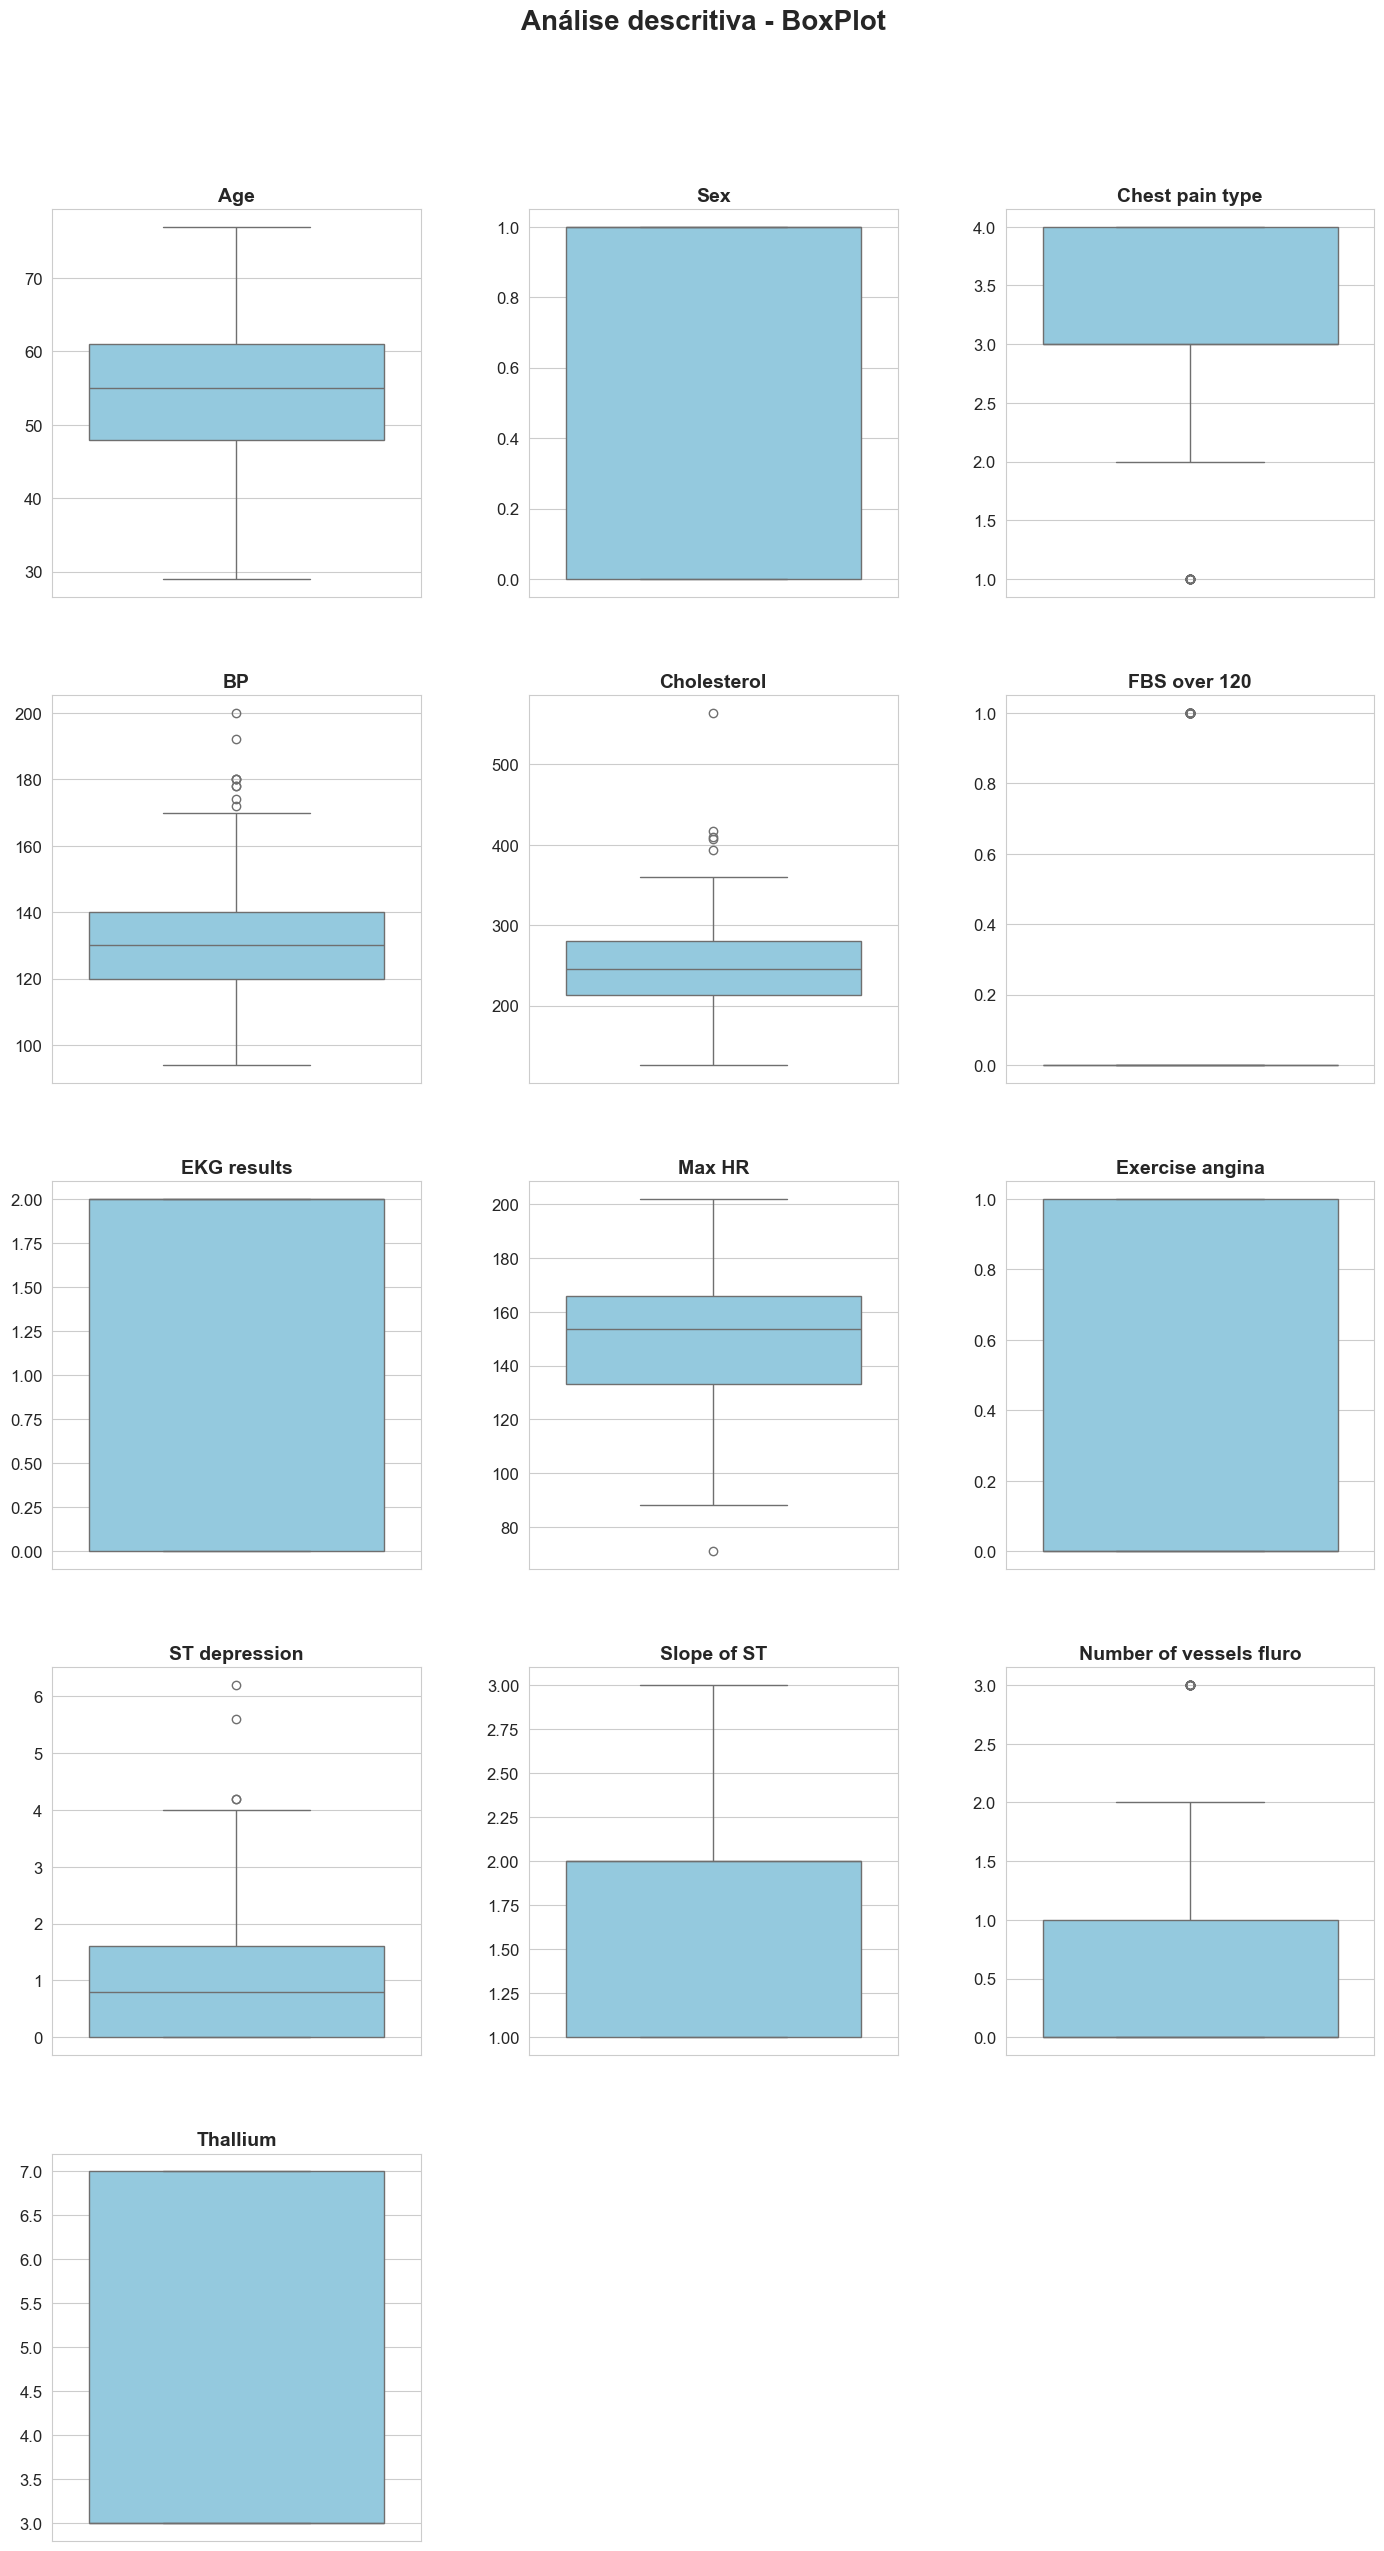

In [13]:
# Plotando os boxplots estilizados com títulos simplificados usando a função definida
box_plot(df_train)

# Preparação dos Dados

In [23]:
# Columns
df_train.columns

Index(['Age', 'Sex', 'Chest_pain_type', 'BP', 'Cholesterol', 'FBS_over_120',
       'EKG_results', 'Max_HR', 'Exercise_angina', 'ST_depression',
       'Slope_of_ST', 'Number_of_vessels_fluro', 'Thallium', 'Heart_Disease'],
      dtype='object')

## Tratamento nome variáveis

In [5]:
# Tratamento nome variáveis
df_train.rename(columns=
                {'Heart Disease': 'Heart_Disease',
                 'Chest pain type': 'Chest_pain_type',
                 'FBS over 120': 'FBS_over_120',
                 'EKG results': 'EKG_results',
                 'Max HR': 'Max_HR',
                 'Exercise angina': 'Exercise_angina',
                 'ST depression': 'ST_depression',
                 'Slope of ST': 'Slope_of_ST',
                 'Number of vessels fluro': 'Number_of_vessels_fluro'

                 }, inplace=True)


### Realizando tratamento no target
* Absence = 0
* Presence = 1


In [6]:
#a alterando o target para numérico
df_train['Heart_Disease'].replace({'Presence': 1, 'Absence': 0}, inplace=True)


In [7]:
# Split

df_train_00, df_test_00 = train_test_split(df_train, test_size=0.3, random_state=42)

df_train_00.shape,df_test_00.shape

((189, 14), (81, 14))

In [8]:
# lista de vars para retirar dos tratamentos
lista_spec = ['Heart_Disease']
df_train_01 = df_train.drop(axis=1,columns = lista_spec)


In [9]:
# Gera metadados
matadata_df =  generate_metadata(df_train_01)
matadata_df

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,Age,int64,0,0.0,41
1,Sex,int64,0,0.0,2
2,Chest_pain_type,int64,0,0.0,4
3,BP,int64,0,0.0,47
4,Cholesterol,int64,0,0.0,144
5,FBS_over_120,int64,0,0.0,2
6,EKG_results,int64,0,0.0,3
7,Max_HR,int64,0,0.0,90
8,Exercise_angina,int64,0,0.0,2
9,ST_depression,float64,0,0.0,39


In [10]:
# Trazendo o target para o dataframe

df_train_02 = df_train_01.merge(df_train[['Heart_Disease']], left_index=True, right_index=True, how='inner')

# Modeling

Número de features selecionadas:  12


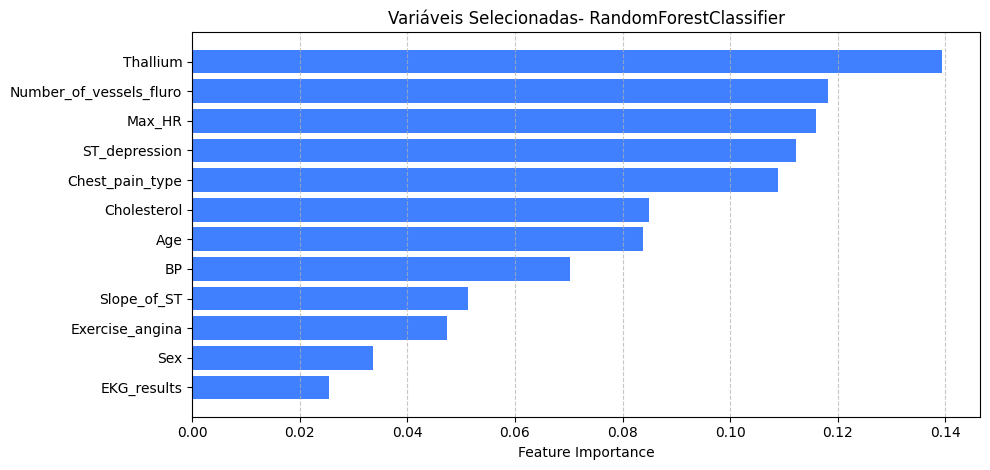

In [61]:
# Feature Selection GradientBoostingClassifier

# Criando X e Y
X_train = df_train_02.drop(axis=1,columns='Heart_Disease')
y_train = df_train_02.Heart_Disease

clf = RandomForestClassifier()
# troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
#RandomForestClassifier
clf.fit(X_train, y_train)
# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.1

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X_train.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ',len(selected_features))

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas- RandomForestClassifier")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

abt_train_fs_gradient = df_train_02[list(selected_features_df.Feature)+['Heart_Disease']]
abt_test_fs_gradient = df_test_00[list(selected_features_df.Feature)+['Heart_Disease']]

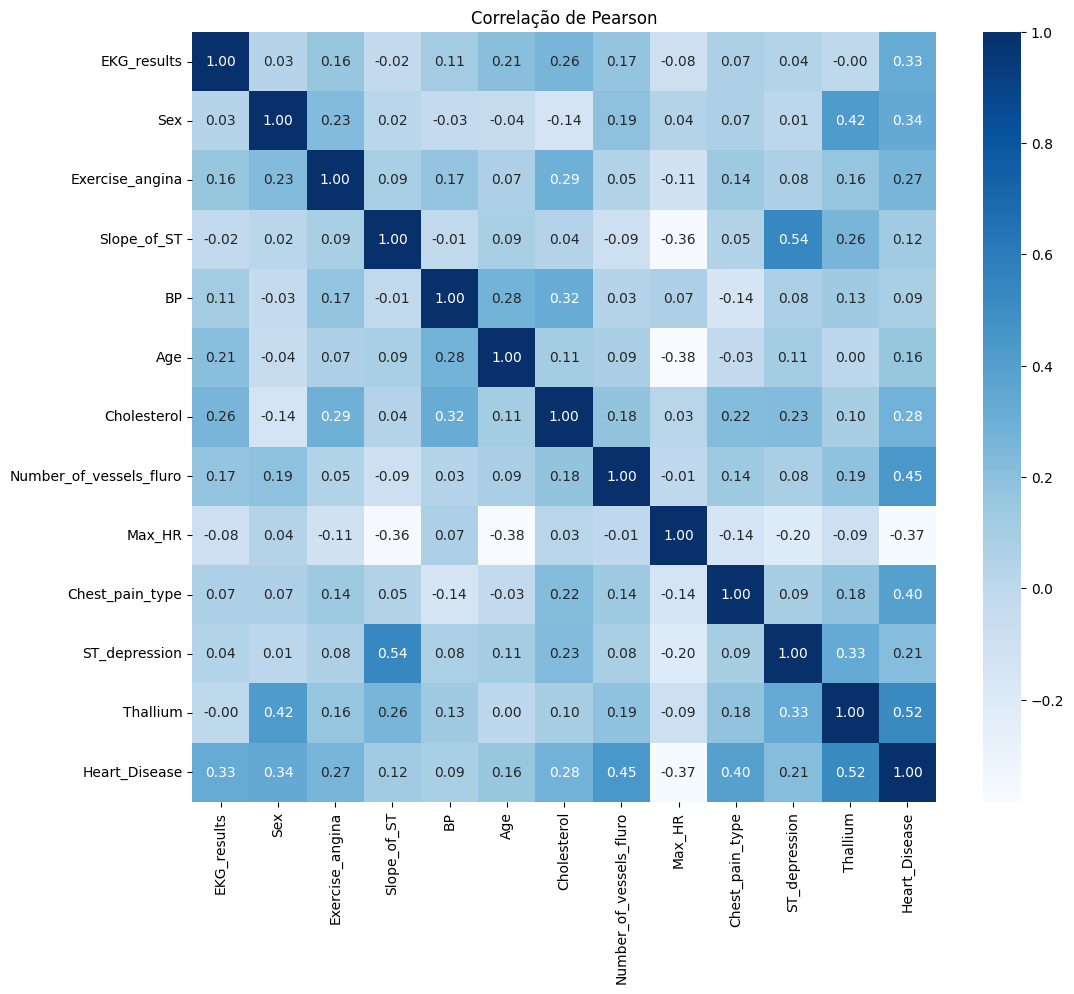

In [44]:
# Calcular a correlação de Pearson
corr_matrix = abt_test_fs_gradient.corr()

# Plotar o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="Blues", annot=True, fmt=".2f")
plt.title("Correlação de Pearson")
plt.show()


In [40]:
lista_features = list(selected_features_df.Feature)+['Heart_Disease']

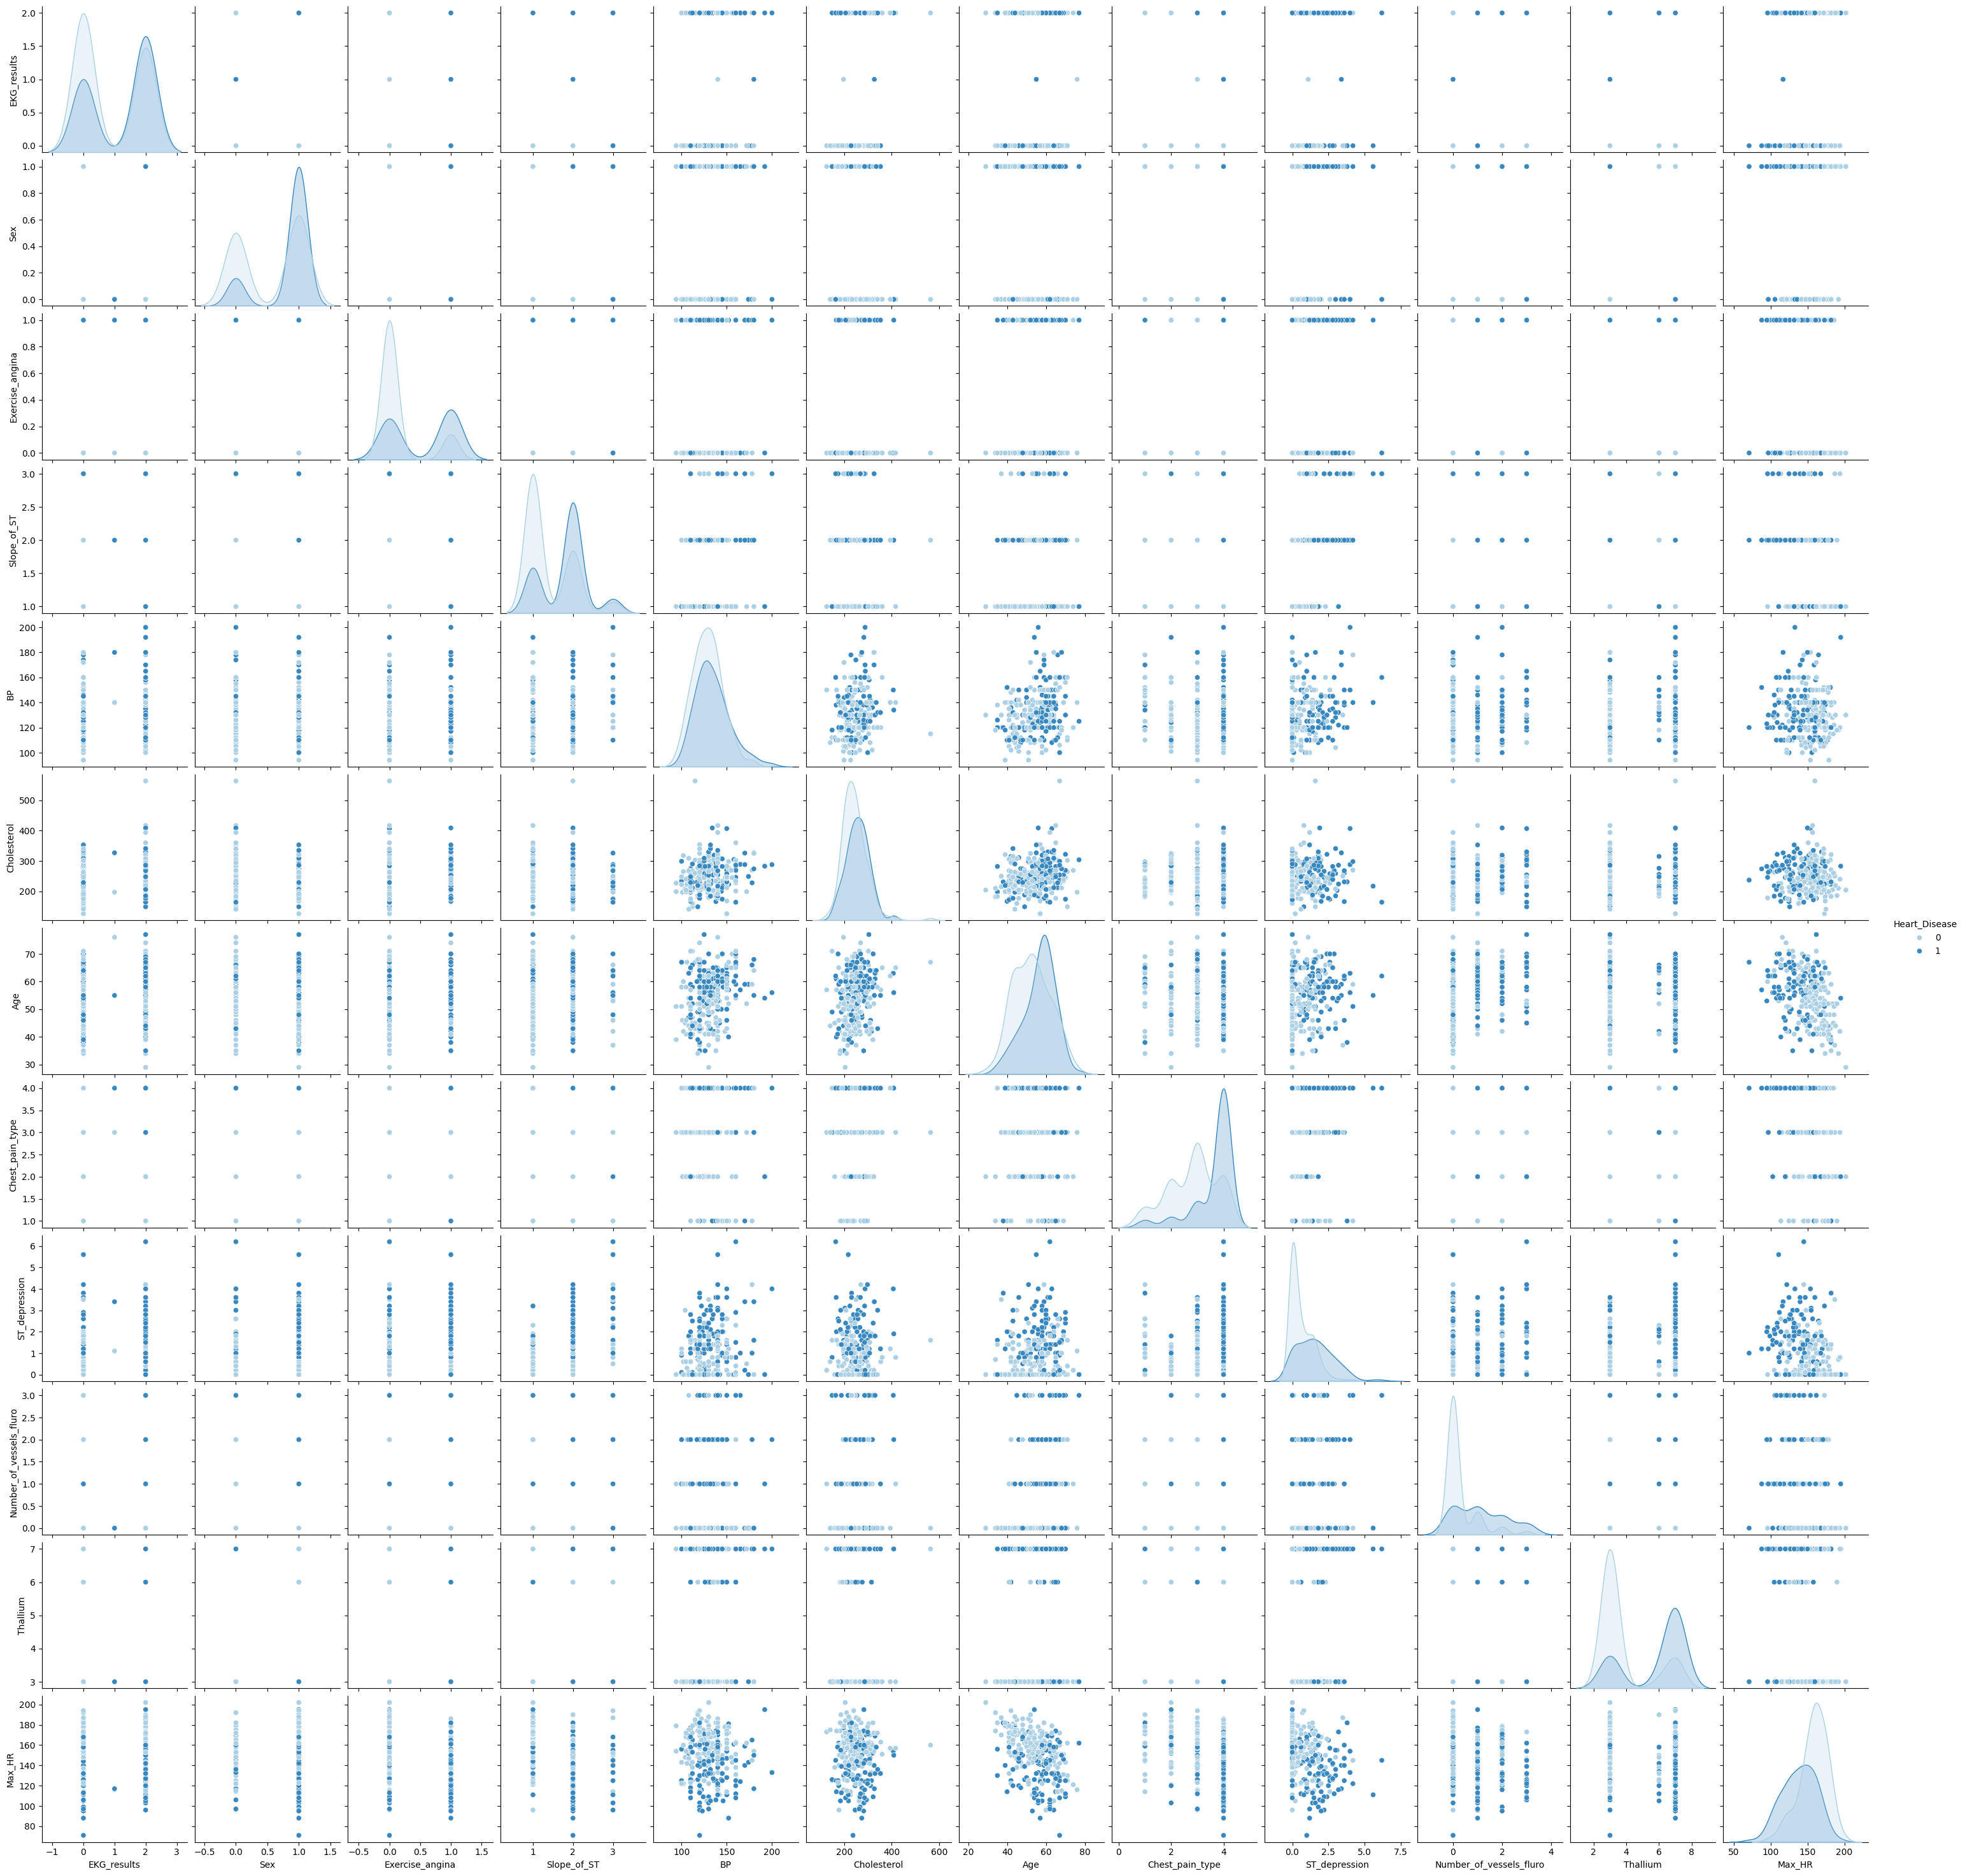

In [41]:
abt_corr_aux_sample = abt_train_fs_gradient
sns.pairplot(abt_corr_aux_sample[lista_features], hue='Heart_Disease', palette='Blues')
plt.show()

In [ ]:
v_df = iv_table(abt_corr_aux_sample, 'Heart_Disease')
iv_df

c:\Users\rei.cardozo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rei.cardozo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rei.cardozo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rei.cardozo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rei.cardozo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered 

,Variável,IV,Preditividade
12,Thallium,1.238192,Preditor Forte
2,Chest_pain_type,1.138256,Preditor Forte
11,Number_of_vessels_fluro,1.043148,Preditor Forte
8,Exercise_angina,0.757381,Preditor Forte
0,Age,0.689485,Preditor Forte
9,ST_depression,0.646895,Preditor Forte
10,Slope_of_ST,0.643662,Preditor Forte
7,Max_HR,0.476065,Preditor Forte
1,Sex,0.390681,Preditor Forte
3,BP,0.241169,Preditor Moderado


In [57]:

# Split para treinamento do modelo

X = abt_train_fs_gradient.drop(axis=1,columns='Heart_Disease')
y = abt_train_fs_gradient.Heart_Disease

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
)

#Definindo o modelo
model = LogisticRegression(max_iter=5000)
model_sgs = LogisticRegression(max_iter=5000)

# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1'],
    'tol':[0.0001,],
    'C': [1.0],
    'solver':['liblinear'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model, param_grid, cv=5,
                    scoring='recall',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rl_fs = grid.best_estimator_

metrics_model  =calculate_metrics('LogisticRegression',best_model_rl_fs, X_train, y_train, X_test, y_test)
metrics_model

Total de Modelos a serem Treinados: 5
Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}
Melhor AUC:  0.8398692810457516
Gini normalizado -->  0.83


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.825397,0.783505,0.863636,0.917192,0.834383,0.741899
1,LogisticRegression,Teste,0.827160,0.750000,0.843750,0.915816,0.831633,0.750000


C:\Users\rei.cardozo\AppData\Local\Temp\ipykernel_6888\285300657.py:299: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
C:\Users\rei.cardozo\AppData\Local\Temp\ipykernel_6888\285300657.py:310: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


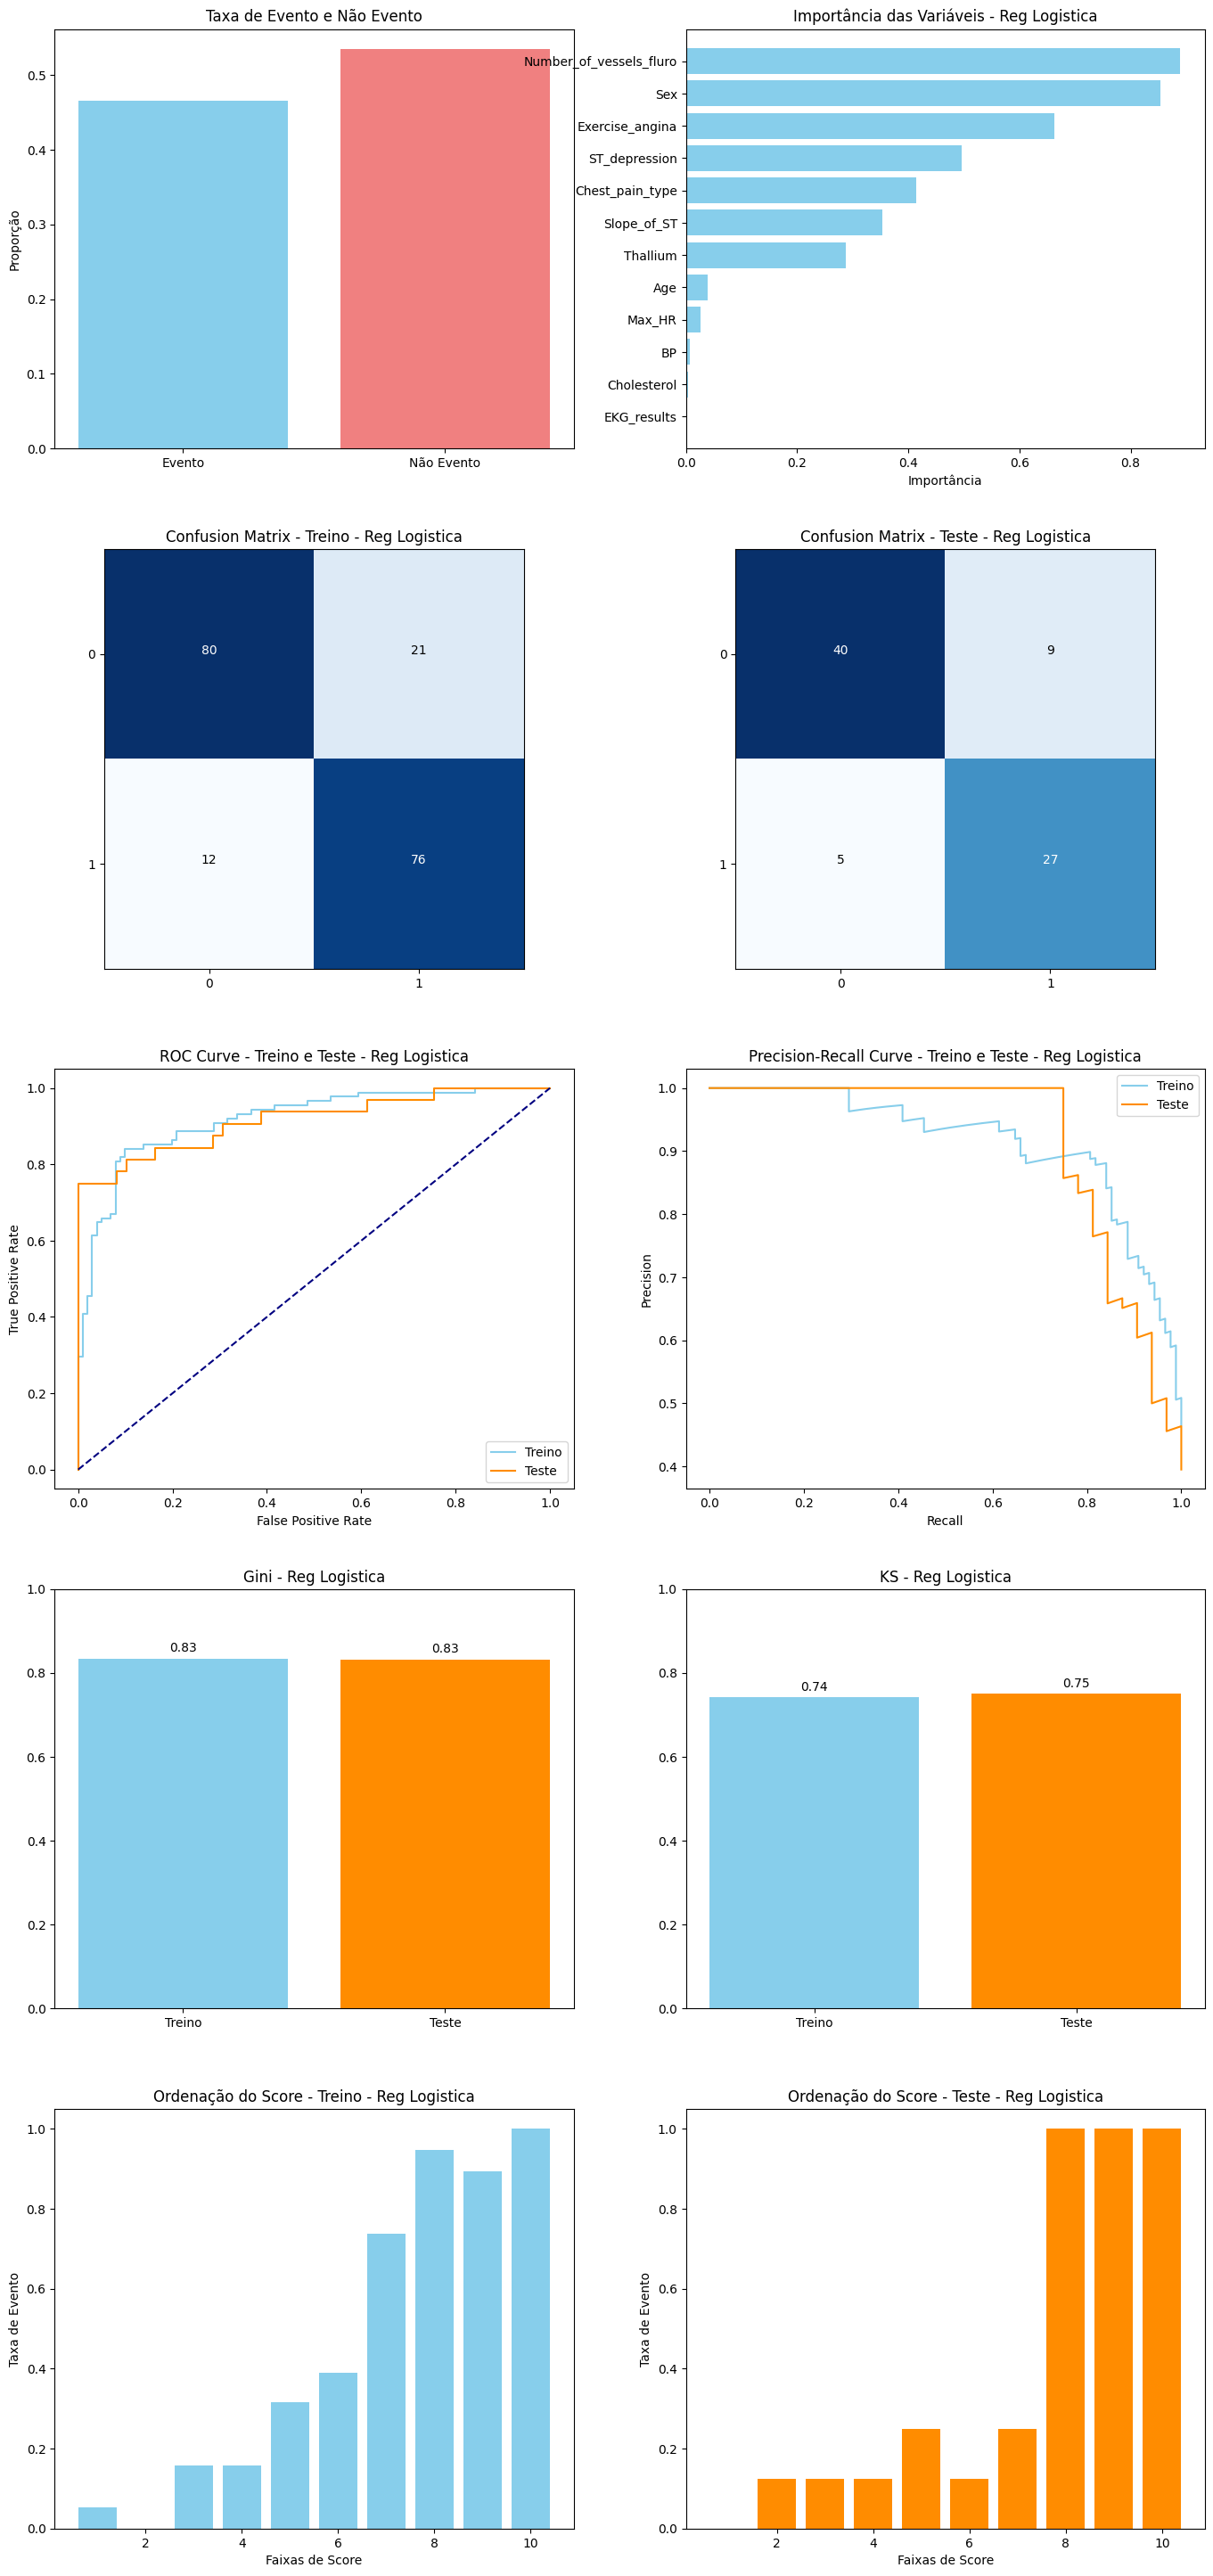

In [60]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rl_fs,nm_modelo='Reg Logistica')